In [5]:
%%javascript
$.getScript('https://kmahelona.github.io/' +
            'ipython_notebook_goodies/' +
            'ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Setup
## Imports

In [2]:
import os
import json
import urllib
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind_from_stats, zscore
%matplotlib inline

## Function

In [3]:
def plotchoropleth(df, feature, ax, colormap):
    """ Plots data from geodataframe with color bar.
    Arguments:
    df - geopandas dataframe.
    feature - column you want to visualize (string).
    ax - matplotlib object to place the plot.
    colormap - matplotlib colormap for plotting (string).
    """
    df.plot(feature, ax=ax, cmap=colormap, linewidth=0.05)
    normalize = mcolors.Normalize(vmin=df[feature].min(),
                                  vmax=df[feature].max())
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(df[feature])
    pl.colorbar(scalarmappaple, ax=ax)

## Download .gz from enigma.io

In [4]:
url = ('https://api.enigma.io/v2/export/' +
       os.environ['ENIGMA_API'] +
       '/us.gov.dol.oflc.perm.2014')

response = urllib.request.urlopen(url)
data = json.loads(response.read().decode('utf-8'))
gz = urllib.request.urlretrieve(data['export_url'], 'visa_data.gz')

## Load data into pandas

In [6]:
# Load enigma data into pandas.
df = pd.read_csv(gz[0], compression='gzip', header=0, sep=',')

# Uppercase relevant fields.
df.employer_name = df.employer_name.str.upper()
df.job_info_work_city = df.job_info_work_city.str.upper()
df.class_of_admission = df.class_of_admission.str.upper()
df.country_of_citizenship = df.country_of_citizenship.str.upper()

# Section 1: Warm Up
## Which companies applied for the most H1B visas in NYC?

In [7]:
nyc = ['NEW YORK', 'BROOKLYN', 'BRONX',
       'QUEENS', 'STATEN ISLAND']

# Query data for only NYC and H1B visas.
nyc_h1b_query = ('job_info_work_city in ' + str(nyc) +
                 ' and class_of_admission == "H-1B"')
nyc_h1b = df.query(nyc_h1b_query)

# Count H1b visas by employer name.
nyc_h1b_group = nyc_h1b.groupby('employer_name')
nyc_h1b_group[['case_no']].count().sort_values(
    'case_no', ascending=False).head(10)

,case_no
employer_name,
BLOOMBERG L.P.,162
ERNST & YOUNG U.S. LLP,138
MPHASIS CORPORATION,125
GOOGLE INC.,70
MORGAN STANLEY & CO. LLC,67
CREDIT SUISSE SECURITIES (USA) LLC,56
NEW YORK CITY DEPARTMENT OF EDUCATION,52
PRICEWATERHOUSECOOPERS,46
"GOLDMAN, SACHS & CO.",45


A foreseable issue when summarizing the data by employer name would be inconsistencies/errors in spelling (e.g., INC v. INC.).

##  Are the wages statistically different between NYC & Mountain View? What could explain the results?

In [8]:
# Query data for only Mountain View and H1B visas.
mv_h1b_query = ('job_info_work_city == "MOUNTAIN VIEW"' +
                ' and class_of_admission == "H-1B"')
mv_h1b = df.query(mv_h1b_query)

# Print out summary statistics for both cities.
print('City, Mean_Wage, StdDev_Wage',
      '\nNYC, {0}, {1}\nMountain View, {2}, {3}'.format(
        nyc_h1b.wage_offered_from_9089.mean().round(2),
        nyc_h1b.wage_offered_from_9089.std().round(2),
        mv_h1b.wage_offered_from_9089.mean().round(2),
        mv_h1b.wage_offered_from_9089.std().round(2)))

City, Mean_Wage, StdDev_Wage 
NYC, 114452.66, 48585.53
Mountain View, 123912.34, 24207.89


In [9]:
# Perform t-test between the two cities.
t, p = ttest_ind_from_stats(
    nyc_h1b.wage_offered_from_9089.mean(),
    nyc_h1b.wage_offered_from_9089.std(),
    len(nyc_h1b.wage_offered_from_9089),
    mv_h1b.wage_offered_from_9089.mean(),
    mv_h1b.wage_offered_from_9089.std(),
    len(mv_h1b.wage_offered_from_9089),
    equal_var=False)

print('T-test: stat={0}, pvalue={1}'.format(t.round(2), p.round(2)))

T-test: stat=-8.43, pvalue=0.0


The average wages between the two are significantly different. Seems likely that the companies in each location are different and pay differently; especially considering how Google is based in Mountain View.

In [10]:
# Check what employer in Mountain View applies for the most VISAs.
mv_h1b_apps = mv_h1b.groupby('employer_name')
mv_h1b_apps[['case_no']].count().sort_values('case_no', ascending=False).head()

,case_no
employer_name,
GOOGLE INC.,608
LINKEDIN CORPORATION,122
MICROSOFT CORPORATION,59
"SYNOPSYS, INC.",36
INTUIT,22


Yep, Google applies for the most H1B visas in Mountain View by a sizeable margin. If Google pays their employees on average more than other companies, that's likely the reason Mountain View has a higher mean salary. 

## For NYC, what is the relationship between the total number of H-1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship?

In [11]:
nyc_h1b_count = nyc_h1b_group[['case_no']].count()
nyc_h1b_salar = nyc_h1b_group[['wage_offered_from_9089']].mean()

# Join count data and mean salary data for H1Bs in NYC.
nyc_h1b_rel = nyc_h1b_count.join(nyc_h1b_salar)

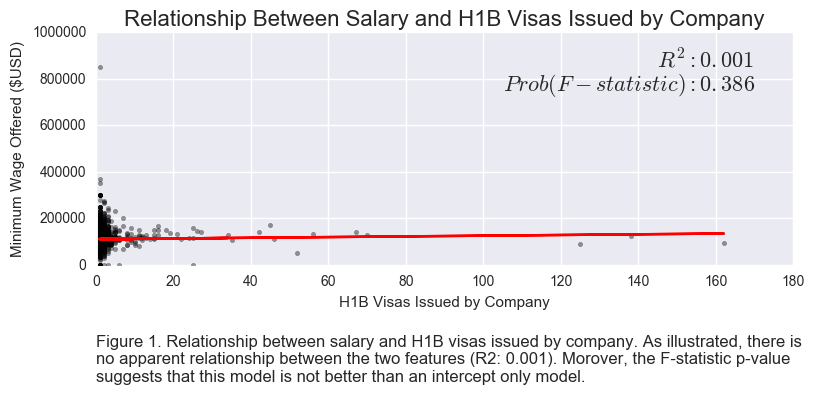

In [12]:
# Perform OLS regression on count and mean salary.
results = smf.ols('wage_offered_from_9089 ~ case_no',
                  data=nyc_h1b_rel).fit()

# Plot resulst.
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(9, 3))

ax1.scatter(nyc_h1b_rel['case_no'],
            nyc_h1b_rel['wage_offered_from_9089'],
            alpha=0.4, s=10, c='k')

ax1.plot(nyc_h1b_rel['case_no'], results.predict(), c='r',
         label='OLS Regression')

ax1.axis([0, 180, 0, 1000000])
ax1.set_ylabel('Minimum Wage Offered ($USD)')
ax1.set_xlabel('H1B Visas Issued by Company')
ax1.set_title('Relationship Between Salary and H1B Visas ' +
              'Issued by Company', fontsize=16)
ax1.text(170, 850000, '$R^2: 0.001$',
         fontsize=16, family='serif', ha='right')
ax1.text(170, 750000, '$Prob (F-statistic): 0.386$',
         fontsize=16, family='serif', ha='right')
ax1.text(0, -500000, 'Figure 1. Relationship between ' +
         'salary and H1B visas issued by company. As ' +
         'illustrated, there is \nno apparent relationship ' +
         'between the two features (R2: 0.001). ' +
         'Morover, the F-statistic p-value \nsuggests that ' +
         'this model is not better than an intercept ' +
         'only model.', fontsize=12)

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     wage_offered_from_9089   R-squared:                       0.001
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                    0.7511
Date:                    Thu, 22 Dec 2016   Prob (F-statistic):              0.386
Time:                            12:43:11   Log-Likelihood:                -16582.
No. Observations:                    1351   AIC:                         3.317e+04
Df Residuals:                        1349   BIC:                         3.318e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.101e+05   1473.346     74.700      0.000      1.07e+05  1.13e+05
case_no      149.6486    172.671      0.867      0.386      -189.084   488.381
==============================================================================
Omnibus:                     1014.898   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58017.939
Skew:                           2.924   Prob(JB):                         0.00
Kurtosis:                      34.567   Cond. No.                         8.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There isn't a significant relationship between the number of H1B visas requested by an employer and the average wages proposed. The wages of H1B visas appears normally distributed, so taking a subsample (a company with multiple applications) is likely to approximate the population mean (i.e., the central limit theorem), not give a meaningful relationship. Only if companies applying for VISAs consistently took a non-representative subsample (e.g., Bloomberg only taking on high paying employees), should there be any kind of relationship.

# Brainstorming
This dataset could be used to answer a variety of interesting questions, like: 

1. What industries apply for the most H1B visas (i.e., what industries have the biggest domestic talent gap)?
2. What countries are successfully training their citizens for in-demands jobs (i.e., where are applicants coming from and for what purpose)?
3. Between the visas offered are there different 'types' (i.e., clusters)?
4. In conjunction with domestic employment data, this data could be used to see if any companies are abusing the VISA system (e.g., are they hiring foreign professionals at a lower salary then domestic professionals).
5. Do different companies hire different nationalities?
6. Where are these VISAs spread out around the US.

# Exploration
I'm a Canadian in New York, so lets see who I should be sending my resume to. In other words: 
### What company in New York paid the most for Canadian professionals in 2014?

In [14]:
# Query data for Canadian H1Bs in NYC.
nyc_h1b_can_query = ('job_info_work_city in ' + str(nyc) +
                     ' and class_of_admission == "H-1B" ' +
                     'and country_of_citizenship == "CANADA"')
nyc_h1b_can = df.query(nyc_h1b_can_query)

# Groupby relevant field and join data.
nyc_h1b_can_group = nyc_h1b_can.groupby('employer_name')
nyc_h1b_can_salar = nyc_h1b_can_group[['wage_offered_from_9089']].mean()
nyc_h1b_can_count = nyc_h1b_can_group[['case_no']].count()
nyc_h1b_can_rel = nyc_h1b_can_count.join(nyc_h1b_can_salar)
nyc_h1b_can_rel[nyc_h1b_can_rel['case_no'] > 1].sort_values(
    'wage_offered_from_9089', ascending=False).head(10)

,case_no,wage_offered_from_9089
employer_name,,
MORGAN STANLEY & CO. LLC,8,214030.5
BARCLAYS CAPITAL INC.,4,190000.0
"GOLDMAN, SACHS & CO.",3,166000.0
MARKIT,2,150842.0
DELOITTE CONSULTING LLP,2,150025.0
CITADEL LLC,2,150000.0
"MCKINSEY & COMPANY, INC UNITED STATES",2,150000.0
"ALIXPARTNERS, LLP",2,148719.0
"DEUTSCHE BANK SECURITIES, INC.",2,146219.0


Well, looks like banking and consulting is where it's at for Canadians in NYC.

This wasn't particularly insightful though... lets see how VISAs are distributed around the US.

### What states applied for the most visas in the continental US in 2014?

In [15]:
# Download state geojson.
response = urllib.request.urlopen('http://eric.clst.org/wupl/' +
                                  'Stuff/gz_2010_us_040_00_20m.json')
data = json.loads(response.read().decode('utf-8'))

In [16]:
# Load geojson in to geopandas dataframe.
states = gpd.GeoDataFrame.from_features(data['features'])

# Clean state names for join.
states['NAME'] = states['NAME'].str.upper()
states.set_index('NAME', inplace=True)
cont_states = states.drop(['ALASKA', 'HAWAII', 'PUERTO RICO'])

# Count VISAs issued by state.
state_visas = df.groupby('job_info_work_state')
states_count = state_visas[['case_no']].count()

# Join state gpd dataframe with state VISA data.
cont_states_count = cont_states.join(states_count)

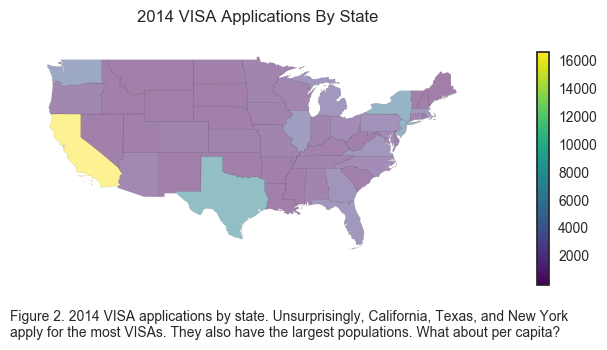

In [18]:
# Plot choropleth of VISAs by state.
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(8, 3))

sns.set_style('white')
sns.despine(ax=ax1, bottom=True, left=True)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

plotchoropleth(cont_states_count, 'case_no', ax1,
               colormap='viridis')
ax1.set_title('2014 VISA Applications By State',
              fontsize=12, y=1.1)
fig.text(0.125, -0.05, 'Figure 2. 2014 VISA applications by state. ' +
         'Unsurprisingly, California, Texas, and New York ' +
         '\napply for the most VISAs. They also have the ' +
         'largest populations. What about per capita?')

As seen, California, Texas, and New York all apply for the most VISAs. They all have the large populations, so do they really apply for the most VISAs per capita?
### What states applied for the most visas per capita in the continental US in 2014?

In [19]:
# Download census population data.
pop_url = ('https://www2.census.gov/programs-surveys/' +
           'popest/tables/2010-2016/state/totals/nst-est2016-01.xlsx')

# Load population data into pandas.
pop = pd.read_excel(pop_url, header=3)

# Clean up index for join.
pop.reset_index(inplace=True)
pop['index'] = pop['index'].str.upper()
pop.set_index('index', inplace=True)
pop.index = pop.index.astype(str).str[1:]
pop.rename(columns={2014: 'y2014'}, inplace=True)
pop_2014 = pop[['y2014']]

In [20]:
# Join population data with state level VISA data.
visa_pc = cont_states_count.join(pop_2014)

# Calculate per capita VISA applications.
visa_pc['VISA_perhunthou'] = (visa_pc['case_no'] /
                              (visa_pc['y2014'] / 100000))

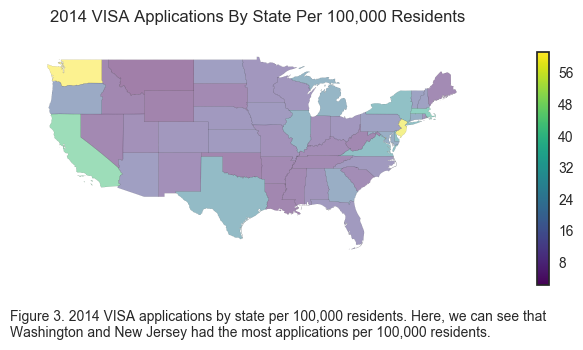

In [21]:
# Plot results.
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(8, 3))

sns.set_style('white')
sns.despine(ax=ax1, bottom=True, left=True)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

plotchoropleth(visa_pc, 'VISA_perhunthou', ax1,
               colormap='viridis')
ax1.set_title('2014 VISA Applications By State Per 100,000 Residents',
              fontsize=12, y=1.1)
fig.text(0.125, -0.05, 'Figure 3. 2014 VISA applications by state ' +
         'per 100,000 residents. Here, we can see that \nWashington ' +
         'and New Jersey had the most applications per 100,000 ' +
         'residents.')

As seen, Washington and New Jersey have the most applications per 100,000 residents. Let's see if this is significant...

In [22]:
# Calculate z-scores for signifcance testing.
visa_pc['z_score'] = zscore(visa_pc.VISA_perhunthou)
visa_pc[['VISA_perhunthou',
         'z_score']].sort_values(
    'z_score', ascending=False).head()

,VISA_perhunthou,z_score
NAME,,
DISTRICT OF COLUMBIA,61.608030,3.139638
WASHINGTON,61.197619,3.110890
NEW JERSEY,59.619041,3.000313
CALIFORNIA,43.202301,1.850350
MASSACHUSETTS,37.111600,1.423707


Whoa, didn't even see DC on the map. But, DC, Washington, and New Jersey all apply for significantly more VISAs per capita than other US states (α=0.05).